<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/bori_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

TODO: nice description of what we want to do, why this is relevant, etc.

## Setup

In [221]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [222]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [241]:
stroke_df = stroke_df.rename(str.lower, axis='columns')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [224]:
def_plot_length = 8
def_fig_size = (def_plot_length, def_plot_length)
def_title_size = 20

## Initial Data Analysis

Goal: 
*   get to know our data
*   see how data should be cleaned
*   find interesting correlations
*   formulate a hypothesis

TODO: write a nice introduction before submitting the assignment :)

In [225]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### Analysing the individual features

#### Gender

In [226]:
stroke_df.groupby('gender').size()
# We only have one other gender type

gender
Female    2994
Male      2115
Other        1
dtype: int64

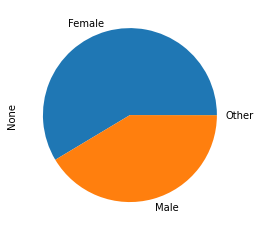

In [227]:
stroke_df.groupby('gender').size().plot(kind='pie')


In [228]:
stroke_df.loc[stroke_df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


#### Age

In [229]:
stroke_df.age.describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64



*   **median age: 45.0**
  *   considering that the **median age in the world is only 30.63**, this dataset seems to describe an **aging population**, probably from one of the highly developed countries
  *   note that only 5 countries in he world have a median age >= 5 (Italy, Saint Pierre and Miquelon, Germany, Japan and Monaco)
  *   source: [worldpopulationreview.com](https://worldpopulationreview.com/country-rankings/median-age)



Text(0.5, 1.0, 'Population Age Distribution')

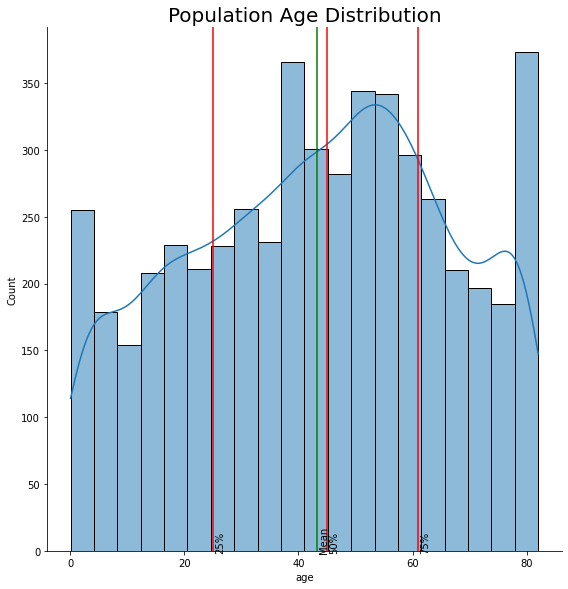

In [230]:
#@ Distribution
sns.displot(data=stroke_df, x="age", kde=True, height=def_plot_length)
# median
disp = 0.4
plt.axvline(x=stroke_df.age.median(),
            color='red')
plt.text(stroke_df.age.median() + disp, 0, "50%", rotation = 90)
# 25%
plt.axvline(x=stroke_df.age.quantile(0.25),
            color='red')
plt.text(stroke_df.age.quantile(0.25) + disp, 0, "25%", rotation = 90)
# 75%
plt.axvline(x=stroke_df.age.quantile(0.75),
            color='red')
plt.text(stroke_df.age.quantile(0.75) + disp, 0, "75%", rotation = 90)
# mean
plt.axvline(x=stroke_df.age.mean(),
            color='green')
plt.text(stroke_df.age.mean() + disp, 0, "Mean", rotation = 90)

plt.title("Population Age Distribution", size=def_title_size)

Text(0.5, 1.0, 'Age Distribution by Stroke Status')

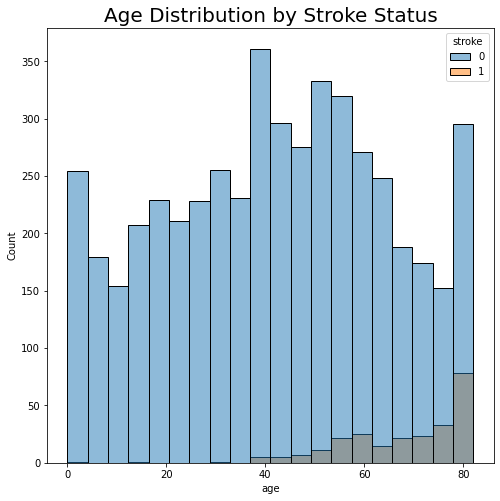

In [231]:
fig, ax = plt.subplots(figsize=def_fig_size)
sns.histplot(data=stroke_df, x="age", hue="stroke", ax=ax)
plt.title("Age Distribution by Stroke Status", size = def_title_size)

Text(0.5, 1.0, 'The ratio of peope having had a stroke, categorized by age')

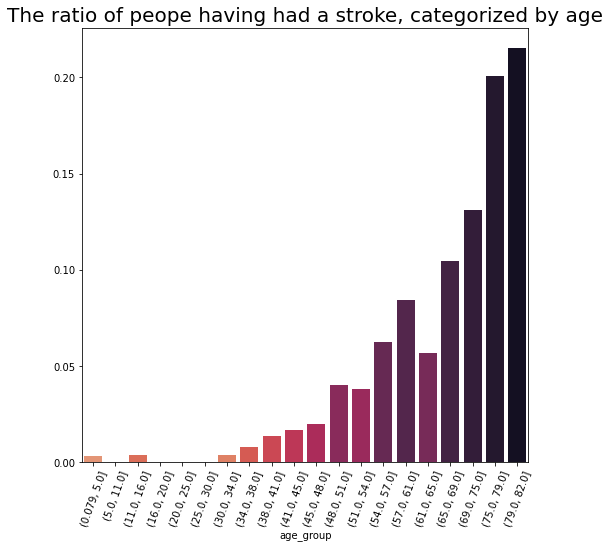

In [232]:
stroke_df_group = stroke_df.copy()
stroke_df_group["age_group"] = pd.qcut(stroke_df_group["age"], q=20)
stroke_ratio_per_age_group = stroke_df_group.groupby(["age_group"]).apply(lambda age_group: age_group["stroke"].sum() / age_group["stroke"].count())
fig, ax = plt.subplots(figsize=def_fig_size)
pal = sns.color_palette("rocket", len(stroke_ratio_per_age_group))
rank = stroke_ratio_per_age_group.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x = stroke_ratio_per_age_group.index, y = stroke_ratio_per_age_group.values, ax = ax, palette = np.array(pal[::-1])[rank])
plt.xticks(rotation=70)
plt.title("The ratio of peope having had a stroke, categorized by age", size = def_title_size)

As expected, the ratio of the population who had a stroke increases by age.

#### Hypertension

#### Heart Disease

In [233]:
heart_disease_value_counts = stroke_df.heart_disease.value_counts()
heart_disease_value_counts

0    4834
1     276
Name: heart_disease, dtype: int64

Only 276 people out of 5110 had a heart disease.

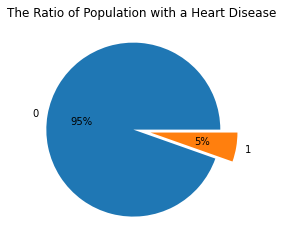

In [243]:
explode = [0.1] * heart_disease_value_counts.count()
plt.pie(heart_disease_value_counts.array, labels=heart_disease_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Ratio of Population with a Heart Disease")
plt.show()

The people with a heart disease represent 5% of the population.

In [280]:
hd_stroke_cnt = stroke_df.groupby(['heart_disease', 'stroke']).count()
hd_stroke_cnt = hd_stroke_cnt.loc[:, :, ] .reset_index().pivot(index='heart_disease', columns='stroke', values='id')
hd_stroke_cnt['stroke_ratio'] = hd_stroke_cnt[1] / (hd_stroke_cnt[0] + hd_stroke_cnt[1])

Text(0.5, 1.0, 'The ratio of peope having had a stroke,\ncategorized by heart disease status')

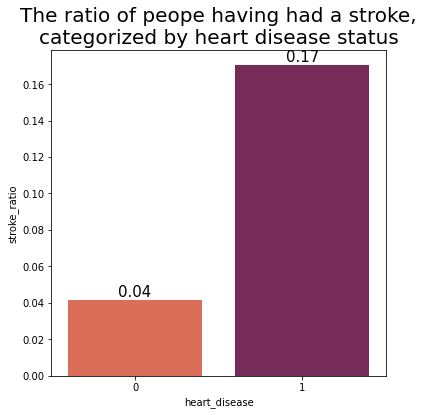

In [284]:
fig, ax = plt.subplots(figsize=(6, 6))
pal = sns.color_palette("rocket", len(hd_stroke_cnt))
rank = hd_stroke_cnt['stroke_ratio'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
plots = sns.barplot(x = hd_stroke_cnt.index, y = hd_stroke_cnt['stroke_ratio'], ax = ax, palette = np.array(pal[::-1])[rank])

# Iterrating over the bars one-by-one to add annotations
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
 

plt.title("The ratio of peope having had a stroke,\ncategorized by heart disease status", size = def_title_size)

As expected, the ratio of people who had a stroke is much higher (17% vs 4%) among people with a heart disease.

#### Marital Status

#### Work Type

#### Residence Type

In [242]:
residence_type_value_counts = stroke_df.residence_type.value_counts()
residence_type_value_counts

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

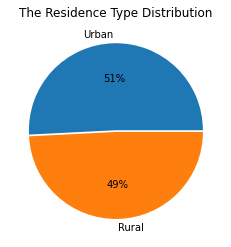

In [245]:
explode = [0.01] * residence_type_value_counts.count()
plt.pie(residence_type_value_counts.array, labels=residence_type_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.title("The Residence Type Distribution")
plt.show()

In [282]:
res_stroke_cnt = stroke_df.groupby(['residence_type', 'stroke']).count()
res_stroke_cnt = res_stroke_cnt.loc[:, :, ] .reset_index().pivot(index='residence_type', columns='stroke', values='id')
res_stroke_cnt['stroke_ratio'] = res_stroke_cnt[1] / (res_stroke_cnt[0] + res_stroke_cnt[1])

Text(0.5, 1.0, 'The ratio of peope having had a stroke,\ncategorized byresidence type')

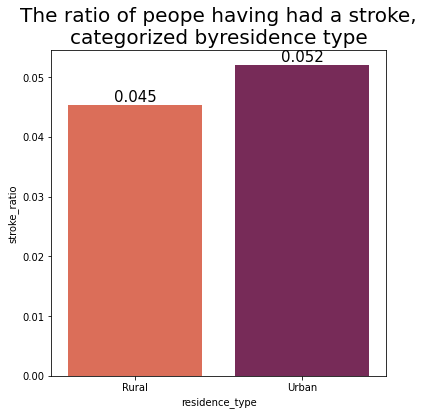

In [286]:
fig, ax = plt.subplots(figsize=(6, 6))
pal = sns.color_palette("rocket", len(res_stroke_cnt))
rank = res_stroke_cnt['stroke_ratio'].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
plots = sns.barplot(x = res_stroke_cnt.index, y = res_stroke_cnt['stroke_ratio'], ax = ax, palette = np.array(pal[::-1])[rank])

# Iterrating over the bars one-by-one to add annotations
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.3f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.title("The ratio of peope having had a stroke,\ncategorized byresidence type", size = def_title_size)

The data shows that people living in an urban area have a slightly higher chance for a stroke (5.2% vs 4.5%), but the residence type does not seem to be a significant factor in one's chance for a stroke.

The people are fairly distributed between twose living in urban and in rural areas.

#### Average Glucoze Level

#### Body Mass Index

#### Smoking Status

### The label: Stroke

## Data Cleaning

### Work Type

### Body Mass Index

### Smoking Status

## Random code

TODO: delete this section

In [236]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [237]:
stroke_df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [238]:
stroke_df.age.map(lambda a: 1 if a >= 16 else 0).value_counts()

1    4366
0     744
Name: age, dtype: int64

In [239]:
stroke_df[stroke_df["age"]<16][stroke_df["work_type"]!="children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4709,41930,Male,15.0,0,0,No,Private,Rural,144.15,24.1,never smoked,0
4806,69723,Male,15.0,0,0,No,Private,Urban,137.27,19.3,never smoked,0
4903,56629,Female,14.0,0,0,No,Private,Rural,83.56,33.1,Unknown,0
4923,72186,Female,15.0,0,0,No,Private,Rural,82.19,40.5,never smoked,0
